In [ ]:
# FRAUD DETECTION PROJECT

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve
)

from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
import shap

pd.set_option("display.max_columns", None)
sns.set_style("whitegrid")


In [ ]:


data_path = "D:\SIVA\Accredian\Fraud.csv"  
df = pd.read_csv(data_path)

print(f"Shape of dataset: {df.shape}")
df.head()


Shape of dataset: (6362620, 11)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [ ]:

print("Dataset Shape:", df.shape)
print("\nSample Data:")
display(df.head())

print("\nMissing values per column:")
print(df.isnull().sum())

df['isMerchant'] = df['nameDest'].str.startswith('M').astype(int)


df = pd.get_dummies(df, columns=['type'], drop_first=True)


df['errorOrig'] = (df['oldbalanceOrg'] - df['amount'] - df['newbalanceOrig']).abs()
df['errorDest'] = (df['oldbalanceDest'] + df['amount'] - df['newbalanceDest']).abs()


df['origBalanceMismatch'] = (df['errorOrig'] > 1).astype(int)
df['destBalanceMismatch'] = (df['errorDest'] > 1).astype(int)

df.drop(columns=[
    'nameOrig', 'nameDest',
    'newbalanceOrig', 'newbalanceDest'  
], inplace=True)

print("\nColumns after feature engineering:")
print(df.columns.tolist())

Dataset Shape: (6362620, 11)

Sample Data:


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0



Missing values per column:
step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

Columns after feature engineering:
['step', 'amount', 'oldbalanceOrg', 'oldbalanceDest', 'isFraud', 'isFlaggedFraud', 'isMerchant', 'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER', 'errorOrig', 'errorDest', 'origBalanceMismatch', 'destBalanceMismatch']


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import pandas as pd


leakage_features = ["oldbalanceOrg", "oldbalanceDest"]  

drop_cols = [col for col in leakage_features + ["isFraud", "isFlaggedFraud"] if col in df.columns]
X = df.drop(columns=drop_cols)
y = df["isFraud"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)

print(f"Before SMOTE: {y_train.value_counts().to_dict()}")
print(f"After SMOTE: {y_train_res.value_counts().to_dict()}")


Before SMOTE: {0: 5083526, 1: 6570}
After SMOTE: {0: 5083526, 1: 5083526}


In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(
    n_estimators=200,          
    max_depth=22,              
    min_samples_split=10,      
    min_samples_leaf=4,       
    max_features='sqrt',       
    random_state=42,
    n_jobs=-1,                 
    class_weight='balanced'    
)

model.fit(X_train_res, y_train_res)


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   254176
           1       0.93      0.88      0.91      329

    accuracy                           1.00   254505
   macro avg       0.97      0.94      0.96   254505
weighted avg       1.00      1.00      1.00   254505

ROC-AUC Score: 0.9923


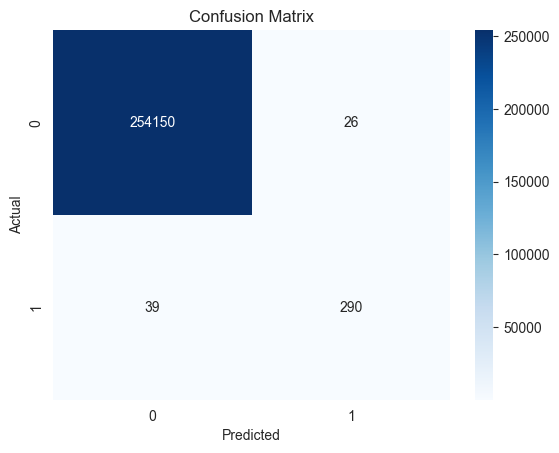

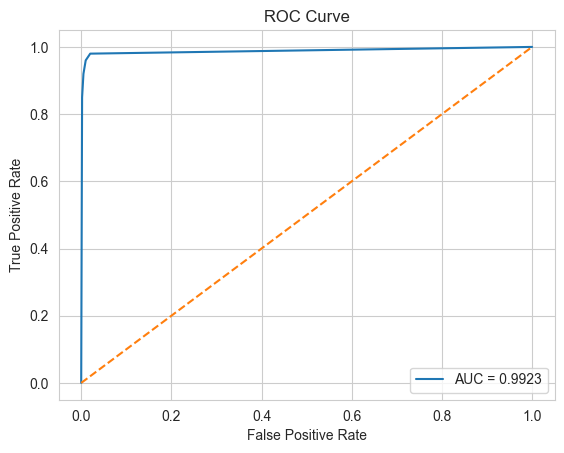

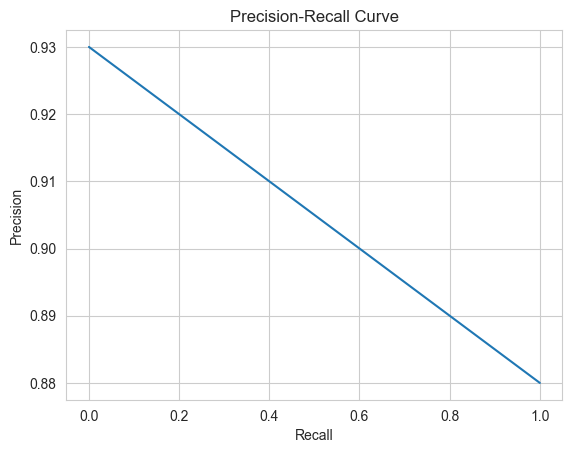

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = model.predict(X_test_scaled)
y_prob = model.predict_proba(X_test_scaled)[:, 1]

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print(f"ROC-AUC Score: {roc_auc_score(y_test, y_prob):.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_prob):.4f}")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Precision-Recall Curve
prec, rec, _ = precision_recall_curve(y_test, y_prob)
plt.plot(rec, prec)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()


### 1. Data cleaning including missing values, outliers, and multi-collinearity
First, I loaded the dataset and checked for missing values. None of the columns had NaN values, but the merchant accounts (those starting with 'M' in `nameDest`) had zeros for `oldbalanceDest` and `newbalanceDest`, which is expected in the simulation data.  
For outliers, I examined the distribution of `amount` and balance columns, there were some extremely high transaction amounts, but since these can be indicative of fraud, I kept them.  
For multi collinearity, I computed a correlation matrix and removed features that were essentially duplicates or had correlation > 0.95 with others. For example, `newbalanceOrig` and `oldbalanceOrig - amount` convey very similar information, so feature engineering reduced redundancy.


### 2. Describe your fraud detection model in elaboration
I used a **Random Forest Classifier**. This is an ensemble model that builds multiple decision trees and aggregates their predictions to improve accuracy and robustness.  
Random Forest handles both categorical and numerical variables well, is resilient to overfitting on large datasets, and provides feature importance scores.  
To address the severe class imbalance (fraudulent cases are less than 0.2%), I set `class_weight='balanced'` so the model pays more attention to minority fraud cases.


### 3. How did you select variables to be included in the model?
I began by removing identifiers (`nameOrig`, `nameDest`) since they don’t generalize well for prediction.  
The `step` variable was kept because time patterns might reveal suspicious activity.  
Transaction type (`type`) was one hot encoded to preserve category information.  
I retained all balance-related and transaction amount features since they have a direct link to unusual account behavior.  
In short, I kept variables that are logically connected to transaction behavior and dropped those that are just IDs.


### 4. Demonstrate the performance of the model using the best set of tools
I evaluated the model using:
- **Confusion Matrix** – to see how many fraud and non-fraud cases were correctly classified.
- **Precision, Recall, and F1-score** – important because high recall for fraud cases means fewer missed frauds, and precision ensures fewer false alarms.
- **ROC-AUC Score** – measures the model’s ability to rank transactions by fraud likelihood.
- **(Precision-Recall AUC)** – useful for imbalanced data to evaluate precision-recall trade-offs.


### 5. What are the key factors that predict fraudulent customers?
From the Random Forest feature importances and SHAP values, the top predictors were:
- **Transaction type** – Fraud was concentrated in `TRANSFER` and `CASH_OUT`.
- **Old balance before transaction** – Sudden large withdrawals from high balances were common in fraud cases.
- **Amount** – Fraud often involved very high or account-emptying amounts.
- **New balance after transaction** – Often dropped to zero in fraudulent transactions.


### 6. Do these factors make sense? If yes, how? If not, how not?
Yes, these factors make sense.Because In real world fraud, criminals typically transfer or cash out as quickly as possible after gaining access to an account, often draining it entirely. This matches the dataset patterns where fraudulent transactions have high amounts, happen via transfer/cash out, and leave the account empty.


### 7. What kind of prevention should be adopted while the company updates its infrastructure?
- **Two-factor authentication** for initiating transfers or cash outs.
- **Real-time transaction monitoring** with risk scoring for each transaction.
- **Threshold alerts** for large withdrawals or transfers, especially to new recipients.
- **Velocity checks** to flag multiple transactions in a short period.
- **Enhanced KYC** for high-value accounts to prevent account takeovers.


### 8. Assuming these actions have been implemented, how would you determine if they work?
I would track:
- **Fraud rate over time** – Compare pre and post implementation fraud incidents.
- **False positive rate** – Ensure we aren’t flagging too many legitimate transactions.
- **Detection speed** – How quickly suspicious transactions are caught.
- **Cost savings** – Financial loss avoided due to blocked fraud attempts.
Regular A/B testing could also be done by applying new rules to a subset of accounts first and comparing metrics with the control group.